In [1]:
import networkx as nx
import time
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
# from networkx.algorithms import community
import community as louvain
import matplotlib.cm as cm
import matplotlib.colors as mpcol
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
from community import community_louvain

%matplotlib inline

In [2]:
import pandas as pd
import osmnx as ox
import networkx as nx

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'1.1.1'

In [3]:
def undirected_network(G):
    G_simple = nx.Graph()
    for i,j,data in G.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G_simple.has_edge(i,j):
            G_simple[i][j]['weight'] += w
        else:
            G_simple.add_edge(i,j,weight=w)
    return G_simple

def find_communities(G):
    start_time = time.time()
    partition = community_louvain.best_partition(G)
    part_dict = {}
    values = []
    for node in G.nodes():
        values.append(partition.get(node))
        part_dict.update({node:partition.get(node)})
    communities_louvain1 = max(values)+1
    end_time = time.time()
    mod_louvain = community_louvain.modularity(partition,G)
    print('Communities found using the Louvain algorithm: {} \nModularity: {} \nTime for finding the communities: {} s'.format(communities_louvain1, mod_louvain,round((end_time-start_time),3)))
    return part_dict


def plot_communities(city_sw):
    
    #List of color
    Color_barragan = ['#E1CF3F','#F47757','#FD4581','#97577C','#BDA7A9','#E1CF3F','#F47757','#FD4581',
                 '#e44623','#e45a6a','#c9d3e6','#7d513d',
                 '#e65949','#d6b240','#382a29','#d8d4c9',
                 '#e4cc34','#ccb42c','#bc8ca4','#3c84c4',
                 '#dd4d3d','#52172f','#63494a','#e2d5d3',
                 '#f7abcc','#e085a1','#943d39','#2d1d19']
    #Create the color map
    Barragan = mpcol.ListedColormap(Color_barragan, name='Barragan')
    G_drive = ox.project_graph(city_sw)
    G_simple = undirected_network(G_drive)
    part_dict = find_communities(G_simple)
    nx.set_node_attributes(G_drive, part_dict, 'community')
    communities = [(G_drive.nodes()[i]['community']) for i in G_drive.nodes()]
    com = [x[1] for x in G_drive.nodes(data='community')]
    norm = mpcol.Normalize(vmin=min(com), vmax=max(com), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=Barragan)
    nc=[mapper.to_rgba(x) for x in com]
    save = True

    fig, ax = ox.plot_graph(G_drive, bgcolor='black', node_color=nc, node_size=8.5, node_zorder=3, node_alpha=1, 
                        edge_linewidth=0.25, edge_color='white',edge_alpha=1,close=True, show=True,
                         save=save)

In [4]:
# get street networks by location name
def get_street_network(location):
    G = ox.graph_from_place(location)
    ox.plot_graph(G)

#get street network from polygon and save to shp
def get_street_network_shp(location, location_name):
    polygon = location.iloc[0]['geometry']
    G = ox.graph_from_polygon(polygon)
    ox.save_graph_shapefile(G, filepath=location_name)
    ox.plot_graph(G)
    return G  

#get network metrics
def get_network_metrics(city_sw, location_name):
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(city_sw)
    gdf_nodes.to_csv('network-metrics/'+location_name+'-nodes.csv')
    gdf_edges.to_csv('network-metrics/'+location_name+'-edges.csv')

    closeness_centrality = nx.closeness_centrality(city_sw)
    closeness_table = pd.DataFrame(list(closeness_centrality.items()))
    closeness_table.to_csv('network-metrics/'+location_name+'-closeness.csv')
    
    betweeness_centrality = nx.betweenness_centrality(ox.get_digraph(city_sw), weight='length')
    betweeness_table = pd.DataFrame(list(betweeness_centrality.items()))
    betweeness_table.to_csv('network-metrics/'+location_name+'-betweeness.csv')

#     page_rank = nx.pagerank(city_sw, alpha=0.8)
#     page_rank_table = pd.DataFrame(list(page_rank.items()))
#     page_rank.to_csv('network-metrics/'+location_name+'-page_rank.csv')
    return gdf_nodes, gdf_edges, closeness_table, betweeness_table 



In [5]:
# load shapefiles of new wave cities

# manila city
manila = gpd.read_file('coe-cities-shp/manila.shp')

# angeles city
angeles = gpd.read_file('coe-cities-shp/Angeles.shp')

# bacolod city
bacolod = gpd.read_file('coe-cities-shp/Bacolod.shp')

# davao city
davao = gpd.read_file('coe-cities-shp/Davao.shp')

# cebu city
cebu = gpd.read_file('coe-cities-shp/Cebu.shp')

# iloilo city
iloilo = gpd.read_file('coe-cities-shp/Iloilo.shp')

# Street Networks

## Manila City

C:\Users\rache\anaconda3\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


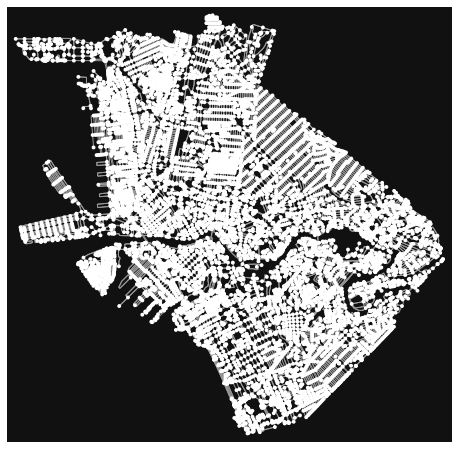

In [6]:
manila_sw = get_street_network_shp(manila, "manila_sw")
manila_sw

In [23]:
get_network_metrics(manila_sw,'manila')

(                    y           x          highway  street_count  \
 osmid                                                              
 12067330    14.559650  120.987162  traffic_signals             4   
 12067342    14.583040  120.975541  traffic_signals             4   
 12067373    14.583493  120.984156  traffic_signals             4   
 12067375    14.584279  120.985600              NaN             3   
 12067384    14.589545  120.981088              NaN             3   
 ...               ...         ...              ...           ...   
 9072616057  14.575318  120.988999              NaN             3   
 9079985123  14.613597  120.971186              NaN             3   
 9079985130  14.613879  120.971169              NaN             3   
 9102904947  14.601965  120.974560              NaN             3   
 9109636299  14.597086  120.969652              NaN             3   
 
                               geometry  
 osmid                                   
 12067330    POIN

Communities found using the Louvain algorithm: 69 
Modularity: 0.9596185062497063 
Time for finding the communities: 2.329 s


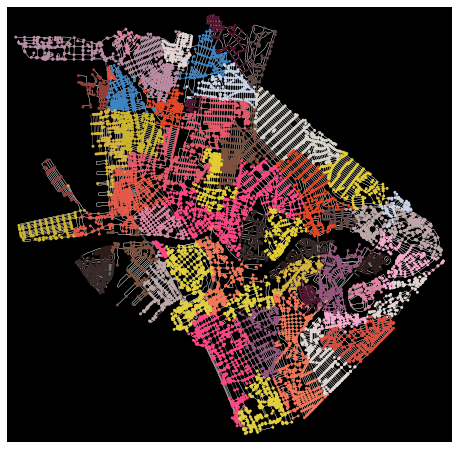

In [8]:
plot_communities(manila_sw)

## Angeles City

C:\Users\rache\anaconda3\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


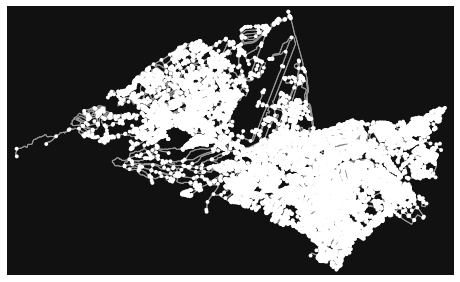

In [9]:
angeles_sw = get_street_network_shp(angeles,'angeles_sw')
angeles_sw

In [25]:
get_network_metrics(angeles_sw,'angeles')

(                    y           x  street_count          highway  ref  \
 osmid                                                                   
 12093631    15.166321  120.559226             4              NaN  NaN   
 12093652    15.167210  120.544953             4              NaN  NaN   
 12093659    15.177698  120.530839             4              NaN  NaN   
 12093660    15.178242  120.530282             4              NaN  NaN   
 12093666    15.184764  120.526954             4  traffic_signals  NaN   
 ...               ...         ...           ...              ...  ...   
 9009978961  15.183216  120.512444             3              NaN  NaN   
 9009978965  15.182623  120.511699             3              NaN  NaN   
 9025615725  15.160851  120.593205             3              NaN  NaN   
 9025615755  15.160902  120.593415             1              NaN  NaN   
 9052633975  15.151990  120.615950             1              NaN  NaN   
 
                               geome

Communities found using the Louvain algorithm: 94 
Modularity: 0.9716738262311356 
Time for finding the communities: 3.346 s


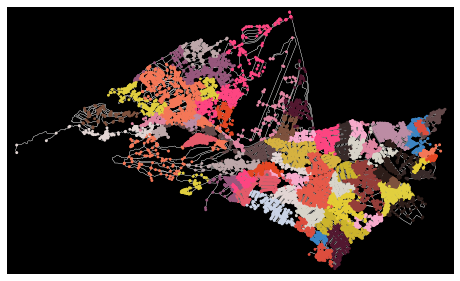

In [10]:
plot_communities(angeles_sw)

## Cebu City 

C:\Users\rache\anaconda3\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


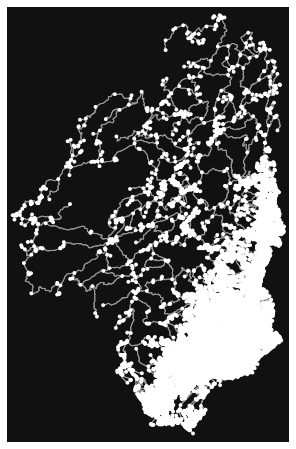

In [11]:
cebu_sw = get_street_network_shp(cebu,'cebu_sw')
cebu_sw

In [27]:
get_network_metrics(cebu_sw,'cebu')

(                    y           x  street_count          highway  \
 osmid                                                              
 280324085   10.303733  123.912716             4              NaN   
 280324090   10.307188  123.909810             4              NaN   
 280324156   10.318554  123.899949             4  traffic_signals   
 280332246   10.311247  123.898198             4  traffic_signals   
 280332314   10.310710  123.903949             4  traffic_signals   
 ...               ...         ...           ...              ...   
 9093398176  10.313564  123.892570             3              NaN   
 9093398178  10.313447  123.892223             1              NaN   
 9096788039  10.325910  123.907490             4              NaN   
 9132013817  10.347763  123.886072             3              NaN   
 9132013820  10.348601  123.885138             1              NaN   
 
                               geometry  
 osmid                                   
 280324085   POIN

Communities found using the Louvain algorithm: 97 
Modularity: 0.9729758456086032 
Time for finding the communities: 2.998 s


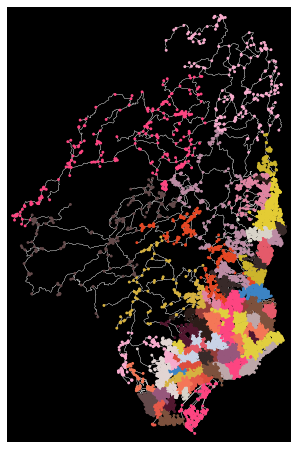

In [12]:
plot_communities(cebu_sw)

## Bacolod City

C:\Users\rache\anaconda3\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


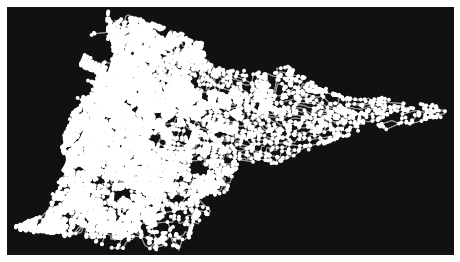

In [13]:
bacolod_sw = get_street_network_shp(bacolod, 'bacolod_sw')
bacolod_sw

In [ ]:
get_network_metrics(bacolod_sw, 'bacolod')

Communities found using the Louvain algorithm: 113 
Modularity: 0.9769691173026986 
Time for finding the communities: 7.699 s


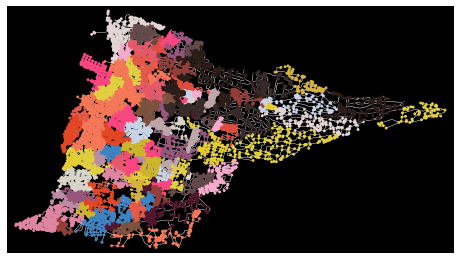

In [14]:
plot_communities(bacolod_sw)

## Davao City

C:\Users\rache\anaconda3\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


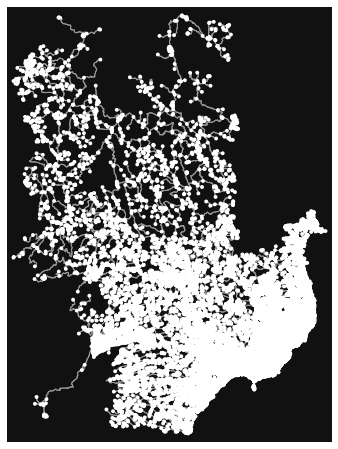

In [7]:
davao_sw = get_street_network_shp(davao, 'davao_sw')
davao_sw

In [ ]:
get_network_metrics(davao_sw,'davao')

Communities found using the Louvain algorithm: 165 
Modularity: 0.9829736608802164 
Time for finding the communities: 8.78 s


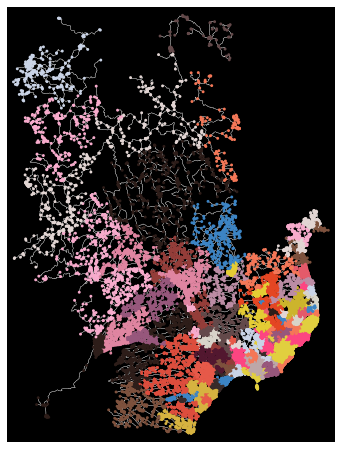

In [16]:
plot_communities(davao_sw)

## Iloilo City 

C:\Users\rache\anaconda3\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


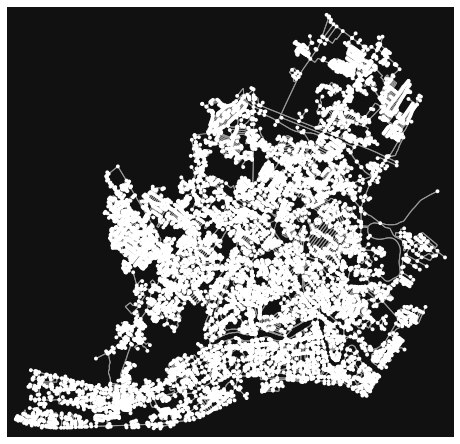

In [6]:
iloilo_sw = get_street_network_shp(iloilo, 'iloilo_sw')
iloilo_sw

In [8]:
get_network_metrics(iloilo_sw,'iloilo')

(                    y           x  street_count highway  \
 osmid                                                     
 355236256   10.725722  122.548940             3     NaN   
 355236301   10.724923  122.549551             3     NaN   
 355236309   10.718825  122.552372             3     NaN   
 355236468   10.709941  122.551552             3     NaN   
 355236473   10.710203  122.551551             3     NaN   
 ...               ...         ...           ...     ...   
 9098824196  10.709729  122.531491             3     NaN   
 9098824197  10.709131  122.532402             3     NaN   
 9114743379  10.705204  122.545511             3     NaN   
 9114743387  10.705122  122.545408             3     NaN   
 9114743392  10.704981  122.545233             3     NaN   
 
                               geometry  
 osmid                                   
 355236256   POINT (122.54894 10.72572)  
 355236301   POINT (122.54955 10.72492)  
 355236309   POINT (122.55237 10.71882)  
 3552364

Communities found using the Louvain algorithm: 84 
Modularity: 0.9690091289942785 
Time for finding the communities: 1.514 s


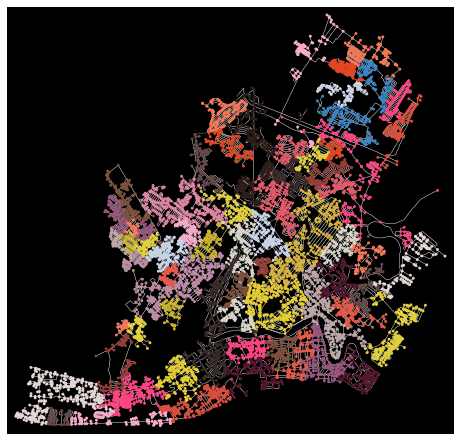

In [18]:
plot_communities(iloilo_sw)